Data extracted from: 
https://portal.spatial.nsw.gov.au/portal/home/item.html?id=3de03ae1965840cfa5dcd9e4018745a7

In [20]:
from __future__ import (absolute_import, division, print_function)
import os

from shapely.geometry import Point, Polygon, MultiPolygon
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt

data_path = "./NSW_BFPL_DATA"

In [2]:
data = gpd.read_file( os.path.join(data_path, "BFPL20210428.shp") )

**Data Overview**

In [47]:
print(data.head())

    StartDate     EndDate  LastUpdate  Category  Guideline  Area  \
0  2016-11-01  3000-01-01  2004-07-11         0          0     1   
1  2016-11-01  3000-01-01  2004-07-11         0          0     0   
2  2016-11-01  3000-01-01  2004-07-11         0          0     0   
3  2016-11-01  3000-01-01  2004-07-11         0          0     0   
4  2016-11-01  3000-01-01  2004-07-11         0          0    28   

     SHAPE_STAr  SHAPE_STLe         d_Category d_Guidelin  \
0  5.055754e-07    0.004058  Vegetation Buffer    Unknown   
1  5.175116e-08    0.000910  Vegetation Buffer    Unknown   
2  1.012477e-07    0.001350  Vegetation Buffer    Unknown   
3  3.057758e-07    0.003138  Vegetation Buffer    Unknown   
4  2.642153e-05    0.082549  Vegetation Buffer    Unknown   

                                            geometry  
0  POLYGON ((150.95902 -29.46138, 150.95902 -29.4...  
1  POLYGON ((150.95139 -29.44723, 150.95116 -29.4...  
2  POLYGON ((151.12162 -29.43128, 151.12139 -29.4...  
3  P

In [48]:
print(data.shape)

(834349, 11)


In [49]:
print(data.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 834349 entries, 0 to 834348
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   StartDate   832789 non-null  object  
 1   EndDate     832798 non-null  object  
 2   LastUpdate  832793 non-null  object  
 3   Category    834349 non-null  int64   
 4   Guideline   834349 non-null  int64   
 5   Area        834349 non-null  int64   
 6   SHAPE_STAr  834349 non-null  float64 
 7   SHAPE_STLe  834349 non-null  float64 
 8   d_Category  832810 non-null  object  
 9   d_Guidelin  832327 non-null  object  
 10  geometry    832810 non-null  geometry
dtypes: float64(2), geometry(1), int64(3), object(5)
memory usage: 70.0+ MB
None


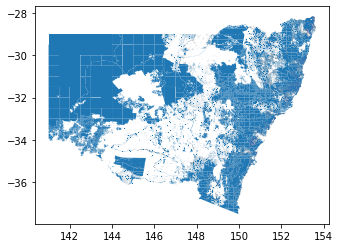

In [4]:
data.plot()

In [5]:
# make a copy
data_copy = data.copy()

In [6]:
# Delete the columns that are not helpful
# Run once ONLY
del data_copy['EndDate']
del data_copy['LastUpdate']
del data_copy['Area']
del data_copy['Category']
del data_copy['Guideline']
del data_copy['SHAPE_STAr']
del data_copy['SHAPE_STLe']
del data_copy['d_Guidelin']

In [7]:
# Check that the columns are successfully deleted
data_copy.columns.to_list()

['StartDate', 'd_Category', 'geometry']

In [8]:
# Only keep the data from 2016, remove others.
time_mask = (data_copy['StartDate'] >= '2016-01-01') & (data_copy['StartDate'] <= '2016-12-31')
data_copy = data_copy.loc[time_mask]

In [9]:
# Remove `None` from the column "vegetation category"
vege_cate_mask = data_copy['d_Category'] != None
data_copy = data_copy.loc[vege_cate_mask]

In [10]:
# Check that the `None`s have been removed
data_copy['d_Category'].unique()

array(['Vegetation Buffer', 'Vegetation Category 1',
       'Vegetation Category 2', 'Vegetation Category 3'], dtype=object)

In [11]:
# "StartDate" column is no longer useful, delete it
del data_copy['StartDate']

In [12]:
# Rename the column "d_Category" to "Vegetation_Category"
data_copy.columns = ['Vegetation_Category', 'geometry']

In [13]:
indices = data_copy.index.values.tolist()
multi_cnt = 0
for idx in indices:
    poly = data_copy.loc[idx, 'geometry']
    if poly.type == 'MultiPolygon':
        multi_cnt += 1
        
print(multi_cnt) # 356 
print(data_copy.shape) 

# The number of data having the "geometry" column of the type "MultiPolygon"
# is far less than the total number of data.
# Hence, ignore them in the following code when restricting the locations 
# to Sydney.

356
(832085, 2)


Geographically, Sydney is fringed by the Tasman Sea to the east,   
the Blue Mountains to the west, the Hawkesbury River to the north   
and the Woronora Plateau to the south.  
Referenced from [City of Sydney](https://www.cityofsydney.nsw.gov.au/guides/city-at-a-glance)  
   
Latitude and Longtitude of:  
* Tasman Sea: 40.8581° S, 160.4313° E  
* Blue Mountains: 33.4100° S, 150.3037° E  
* Hawkesbury River: 33.5305° S, 151.2419° E   
* Woronora Plateau: 34.0365° S, 151.0225° E  
  
For longtitude, take Tasman Sea as the upper bound and Blue Mountains as the lower bound.  
For latitude, take Woronora Plateau as the upper bound and Hawkesbury River as the lower bound.   

In [14]:
syd_long_upper = 160.4313
syd_long_lower = 150.3037
syd_lat_upper = 34.0365 
syd_lat_lower = 33.5305


# the indices of the areas that are not in Sydney
indices_to_remove = []

# the indices taht the data frame currently has
indices = data_copy.index.values.tolist()

for idx in indices:
    poly = data_copy.loc[idx, 'geometry']
    
    if poly.type == 'MultiPolygon':
        indices_to_remove.append(idx)
        continue # skip the data of the type MultiPolygon
        
    long, lat = poly.exterior.coords.xy
    is_continue = True # is continue to execute the next for loop
    
    for lo in long:
        if abs(lo) > syd_long_upper or abs(lo) < syd_long_lower: # not in Sydney
            indices_to_remove.append(idx)
            is_continue = False
            break
            
    if not is_continue: # longtitude already out of bounds, stop going further, continue to next row
        continue
        
    for la in lat:
         if abs(la) > syd_lat_upper or abs(la) < syd_lat_lower: # not in Sydney
            indices_to_remove.append(idx)
            break


# delete the rows that are not in sydney
data_copy = data_copy.drop(labels=indices_to_remove, axis=0)      

In [15]:
print(data_copy.shape)

(6734, 2)


In [29]:
# Reset indices so that the index starts from 1
length = len(data_copy.index)
indices = range(1, length + 1)
data_copy.index = indices
data_copy

,Vegetation_Category,geometry
1,Vegetation Buffer,"POLYGON ((150.30653 -33.63258, 150.30643 -33.6..."
2,Vegetation Buffer,"POLYGON ((150.30566 -33.64810, 150.30556 -33.6..."
3,Vegetation Buffer,"POLYGON ((150.31242 -33.68166, 150.31275 -33.6..."
4,Vegetation Buffer,"POLYGON ((150.32190 -33.61343, 150.32211 -33.6..."
5,Vegetation Buffer,"POLYGON ((150.31249 -33.64882, 150.31260 -33.6..."
...,...,...
6730,Vegetation Category 2,"POLYGON ((150.59035 -33.70660, 150.59040 -33.7..."
6731,Vegetation Category 2,"POLYGON ((150.53257 -33.70141, 150.53238 -33.7..."
6732,Vegetation Category 2,"POLYGON ((150.57607 -33.69341, 150.57607 -33.6..."
6733,Vegetation Category 2,"POLYGON ((150.60549 -33.75374, 150.60553 -33.7..."


In [30]:
# Finish cleaning 
# Export the cleaned data
data_copy.to_file('data_cleaned',driver ='ESRI Shapefile')

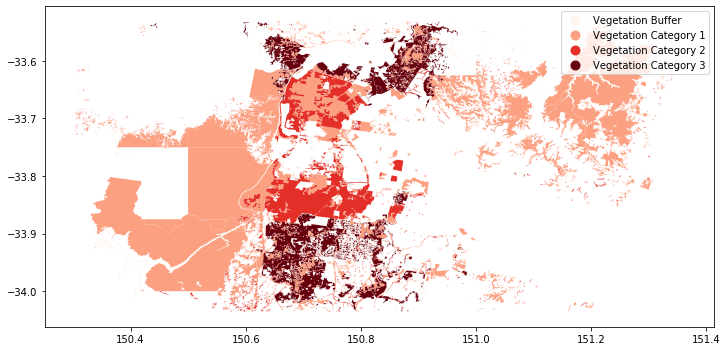

In [46]:
%matplotlib inline
map_df = pd.DataFrame(
    {'vege_category': data_copy['Vegetation_Category'],
     'geom': data_copy['geometry']
    })
gpd_map_df = gpd.GeoDataFrame(map_df, geometry='geom')

# df.plot(kind='scatter', x='x', y='y', label='Scatter')
# plt.legend(loc='lower left')
# plt.show()

fig, ax = plt.subplots(1, figsize=(12,6))
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))  # reverse both handles and labels
gpd_map_df.plot(ax=ax, cmap='Reds', column = 'vege_category', legend=True)